In [1]:
import tweepy
from datetime import datetime
from dateutil.parser import parse
from IPython.display import clear_output
import json
import pandas as pd
from time import sleep
import datetime
import os
from textblob import TextBlob
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
#import twitter apps configaration file from config.py file
from config import keys as k
import operator

Players=["GamsuOW","STRIKER_OW","blaseOW","aimgod_ow","KellexOW","HarryHook","MickiePP",
        "DF_aKm","uNKOE","OGE_ow","HAGOPEUN_OW","minon501","MisfitsTviQuE","xepher123",
        "Apply","Muma","BaniOW","Forceboink","LiNkzrOW","coolmatt69","Birdring","Anamo_ow","tf2pine",
        "Mano_OWL","Boombox","carpe_ow","snillo_ow","SADO_OW","smurf_ow","moth_ow","Shock_CHB","karivow",
        "super_OW","KING_BABYBAY" ,"BdosinOW","NUS_OW","Furyy_d","Surefour","BischuGG", "Shaz_OW","Hydration",
        "spaceOW","Custa","agilities","Fate_ow","saebyeolbe","MekOppa"]
print(len(Players))
Teams={ "Boston Uprising":["GamsuOW","STRIKER_OW","blaseOW","aimgod_ow","KellexOW"],
       "Dallas Fuel":["HarryHook","MickiePP","DF_aKm","uNKOE","OGE_ow"],
       "Florida Myham":["HAGOPEUN_OW","minon501","MisfitsTviQuE","xepher123", "Apply"],
       "Outlaws":["Muma","BaniOW","Forceboink","LiNkzrOW","coolmatt69"],
        "London Spitfire":["Birdring","BdosinOW","NUS_OW","Furyy_d"],
        "LA Glad":["Surefour","BischuGG", "Shaz_OW","Hydration"],
        "LA Val":["karivow","spaceOW","Custa","agilities","Fate_ow"],
        "New York Excel":["saebyeolbe","MekOppa","Anamo_ow","tf2pine","Mano_OWL"],
        "PHILADELPHIA FUSION":["Boombox","carpe_ow","snillo_ow","SADO_OW"],
        "SAN FRANCISCO SHOCK":["smurf_ow","moth_ow","Shock_CHB","super_OW","KING_BABYBAY"]}


47


In [42]:
class tweets():
    def __init__(self,keys):
        #Authentication using keys & accesstoken
        auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)
        auth.set_access_token(keys.access_token, keys.access_token_secret)
        self.api = tweepy.API(auth)
    def get_info_about_user(self,user_name):
        #Donal Trump Twitter account
        user = self.api.get_user(user_name)
        print("Name:", user.name)
        print("User id: ", user.id_str)
        print("Description: ", user.description)
        print("Location:",user.location)
        print("Time zone: ", user.time_zone)
        print("Number of Following:",user.friends_count)
        print("Number of Followers:",user.followers_count)
        print("Number of tweets: ", str(user.statuses_count))
    def get_realtions(self,user_id,fo,fr):
        df= pd.DataFrame(columns=['from','to','created_at'])
        tmplst=[]
        x=0
        for user in tweepy.Cursor(self.api.followers, screen_name=user_id).items(fo):
            if x==270:
                print ('[-] Timeout, sleeping for 15 minutes...',len(tmplst))
                sleep(15*60)
                x=0
            clear_output()
            tmplst.append({ 'from':user.screen_name,
                            'to':user_id,
                            'created_at':user.created_at})
            print('Followers:',(round(((len(tmplst)/fo)*100),2)),'%')
            x=x+1     
        
        check=len(tmplst)
        
        print ('followers done sleeping for 15 minutes before friends...',len(tmplst))
        
        for user in tweepy.Cursor(self.api.friends, screen_name=user_id).items(fr):
            if x==270:
                x=0
            
            clear_output()
            tmplst.append({ 'from':user_id,
                            'to':user.screen_name,
                            'created_at':user.created_at})
            print('Friends:',(round((((len(tmplst)-check)/fr)*100),2)),'%')
            x=x+1   
        df= pd.DataFrame(tmplst)
        clear_output()
        print('Ding!')
        return df
        
    def make_edglst (self,df,name):
        print('Working on file creation...')
        file = open(name+'.txt',"w+") 
        for index, row in df.iterrows():
            string=(row['from']+','+row['to']+','+str(row['created_at']))
            file.write(string+'\n') 
        file.close()
        print('file creation finshed')
    def common_follower(self,g):
        templst=[]
        for node in g.nodes:
            if node != (Players):
                if g.out_degree(node)>=2:
                    templst.append({node})
        return templst
    def popteam(self, G):
        dic={}
        
        for team in Teams:
            comp=0
            for player in Teams[team]:
                if len(list(G.predecessors(player)))>comp:
                    dic.update({team:player})
                    comp=len(list(G.predecessors(player)))
        return dic
    def info (self,g):
        bet=nx.betweenness_centrality(g)
        clos=nx.closeness_centrality(g)
        pager=nx.pagerank(g,alpha=0.9)
        degc=dict(g.in_degree)
        dego=dict(g.out_degree)
        cenmes={
        'in degree':degc,
        'out degree':dego,
        'betweenness':bet,
        'close':clos,
        'page_rank':pager    
        }
        centrality=pd.DataFrame(cenmes)
        centrality
        sns.pairplot(centrality)
    def follower_timeplot(self,g,node):
        dic={node: list(g.predecessors(node))}
        lst=[]
        D={}
        benchMark = datetime.datetime.strptime('2017-01-01', "%Y-%m-%d") 
        for item in dic[node]:
            lst.append(g[item][node]['Timecreated'])
        D = {x:lst.count(x) for x in lst}
        for item in lst:
            if item<benchMark:
                lst.remove(item)
        df= pd.Series(D, name='DateValue')
        df.index.name = 'Date'
        df.columns=['cnt'] 
        df.reset_index()
        #df=df[(df['Date'] > '2017-01-01') & (df['Date'] < '2018-02-01')]
        #print (df.dtypes)
        df=df.loc[df.index > '2018-01-01']
        df.plot(figsize=(10,4),kind='line',title=" Follower graph")

    def find_most_popular_player(self,G):
        cat=dict(G.out_degree)
        mostPopular=max(cat.items(), key=operator.itemgetter(1))[0]
        return mostPopular

In [43]:
t=tweets(k)  

In [ ]:
templist=[]#this grabs data do not run unless need data
for name in Players:
    print(name,(round(((len(templist)/len(Players))*100),2)),'%')
    tempdf=t.get_realtions(name,1000,40)
    t.make_edglst(tempdf,name)
    templist.append(tempdf)
    print ('next loop starts in 15 min')
    sleep(15*60)
   
    


Followers: 27.0 %
[-] Timeout, sleeping for 15 minutes... 270


In [37]:
G=nx.read_edgelist("combg.txt",delimiter=',', create_using=nx.DiGraph() , data=(('Timecreated',str),))#making the graph
for edge in G.edges:# this is to get rid of hr min sec and just leave the day
    x,y=edge
    G[x][y]['Timecreated']=datetime.datetime.strptime(G[x][y]['Timecreated'][:-9], '%Y-%m-%d')
#G.in_degree
#g.nodes()
nx.info(G)



'Name: \nType: DiGraph\nNumber of nodes: 20130\nNumber of edges: 47775\nAverage in degree:   2.3733\nAverage out degree:   2.3733'

In [16]:
nx.is_connected(G.to_undirected())

True

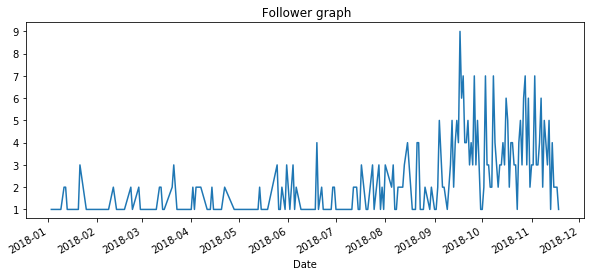

In [35]:
t.follower_timeplot(G,"STRIKER_OW")#where the graph is made

In [7]:
print(t.common_follower(G)[:100])
print("amount of common followers: ",len(t.common_follower(G)))

[{'friydis'}, {'Hydration'}, {'Rainseoked'}, {'Kydronic'}, {'onqyu'}, {'ver369pi'}, {'sneakythiefer'}, {'TheBuckyBear'}, {'satirant'}, {'Cuhtzy'}, {'jvnie'}, {'Ceiaaaaa'}, {'Guster0245'}, {'livingd77167445'}, {'regan_789'}, {'BenQc_'}, {'Atomme1T'}, {'Brostein3'}, {'tricitylegal'}, {'alhanadelrey'}, {'99mehul'}, {'Contenders_OW'}, {'yapyapthedestr1'}, {'Folabi81431934'}, {'uhh_mae'}, {'G0DHIMSELF_'}, {'ephemehral'}, {'cjmy8'}, {'NootNoot_OW'}, {'winter__ow'}, {'Thanos_OW'}, {'foggo_'}, {'do_n4n'}, {'woeman7'}, {'Daevidx'}, {'rianowx'}, {'kusozakotroll'}, {'ackhlys'}, {'McFireFlyOW'}, {'FarBeyondNick'}, {'StefanGarofalo'}, {'JerG_San'}, {'MxPhoKing'}, {'_bluering_'}, {'Ian23343072'}, {'_Naxt_'}, {'EclipseOwlVGC'}, {'IsmailChina2'}, {'gambino_rino'}, {'Solar50628559'}, {'RTheo46'}, {'SneakyUmbra2'}, {'RhysGri29422678'}, {'ItsMrsRobot'}, {'crisbritos95'}, {'55Bluefirefox'}, {'ComodoMc'}, {'Sam50091326'}, {'itsonyxlol'}, {'jacobwood271'}, {'chlomason_x'}, {'Golden_nuggett'}, {'aotterbekk'}

In [27]:
t.popteam(G)

{'Boston Uprising': 'STRIKER_OW',
 'Dallas Fuel': 'DF_aKm',
 'Florida Myham': 'HAGOPEUN_OW',
 'Outlaws': 'LiNkzrOW',
 'London Spitfire': 'Birdring',
 'LA Glad': 'Hydration',
 'LA Val': 'Fate_ow',
 'New York Excel': 'saebyeolbe',
 'PHILADELPHIA FUSION': 'snillo_ow',
 'SAN FRANCISCO SHOCK': 'smurf_ow'}

In [45]:
t.find_most_popular_player(G)

'Apply'